In [11]:
import numpy as np

from scipy import integrate
from scipy import linalg
from scipy import spatial

from scipy import special

from scipy import stats

from scipy.optimize import fsolve

import networkx as netx

import itertools

import random

from jupyterthemes import jtplot

jtplot.style(theme='grade3',context='talk',fscale=1.4, spines=True, gridlines='--')

import matplotlib.pyplot as plt

import cycler


### Food web model from paper

In [2]:
def f_trophic(t,y,A,r,K,N): 
    
    y = np.asarray([i if i > 10**-6 else 0 for i in y])
    
    ydot = np.zeros(len(y))

    ydot[:ind_pp] = y[:ind_pp]*( r[:ind_pp] - y[:ind_pp]*r[:ind_pp]/K - A.T[:ind_pp]@(x*cmax*y/(1 + (x*cmax*(h*A).T).T@y))  )

    ydot[ind_pp:] = y[ind_pp:]*( -r[ind_pp:] + eps*x[ind_pp:]*cmax[ind_pp:]*(A[ind_pp:]@y)/(1 + (x[ind_pp:]*cmax[ind_pp:]*((h*A)[ind_pp:]@y))) - A.T[ind_pp:]@(x*cmax*y/(1 + (x*cmax*(h*A).T).T@y)) )

    return ydot

### Function for uninvadable solution

In [3]:
def f_trophic_ui(t,y,A,diag,r,K,N, ind_pred, h, cmax, x, eps):
    ## diag parameter makes diagonal more negative for uninvadability
    y = np.asarray([i if i > 10**-6 else 0 for i in y])
    
    y[:ind_pred] = y[:ind_pred]*( r[:ind_pred] - (1+diag)*y[:ind_pred]*r[:ind_pred]/K - A.T[:ind_pred]@(x*cmax*y/(1 + (x*cmax*(h*A).T).T@y))  )
    
    y[ind_pred:] = y[ind_pred:]*( -r[ind_pred:] - (diag)*y[ind_pred:]*r[ind_pred:] + eps*x[ind_pred:]*cmax[ind_pred:]*(A[ind_pred:]@y)/(1 + (x[ind_pred:]*cmax[ind_pred:]*((h*A)[ind_pred:]@y))) - A.T[ind_pred:]@(x*cmax*y/(1 + (x*cmax*(h*A).T).T@y)) )
    
    return y

### Type 2 inverse sensitivity matrix for fitness gradient

In [4]:
def jac_type2(A,y,r,N):
    
    y_stacked = np.tile(y, (N,1)).T
    
    j = np.zeros((N,N))
    
    h_jac = np.delete(h, ind_pp, 0)
    
    h_jac = np.delete(h_jac, ind_pp, 1)
    
    x_jac = np.delete(x, ind_pp, 0)
    
    cmax_jac = np.delete(cmax, ind_pp, 0)
    
    eps_jac = np.delete(eps, 0, 0)
    
    ##3x15 matrix with only -r/K along diagonal
    
    iden_pp = np.asarray([ [ -r[i]/K[i] if i==j else 0 for j in range(N)] for i in range(ind_pp) ])
    
    j[:ind_pp] =  -A.T[:ind_pp]*( x_jac*cmax_jac/(1 + (x_jac*cmax_jac*(h_jac*A).T).T@y_stacked[:,:ind_pp]).T ) + ( ( x_jac*cmax_jac*A.T[:ind_pp]*(y_stacked[:,:ind_pp].T) )/((1 + (x_jac*cmax_jac*(h_jac*A).T).T@y_stacked[:,:ind_pp] )**2).T )@(x_jac*cmax_jac*(h_jac*A).T).T + iden_pp
        ## Note that first term also contains diagonal contribution from the derivative of the denominator
        
    j[ind_pp:] = (eps_jac*x_jac[ind_pp:]*cmax_jac[ind_pp:]*A[ind_pp:].T).T/(1 + ( x_jac[ind_pp:]*cmax_jac[ind_pp:]*((h_jac*A)[ind_pp:].T) ).T@y_stacked) - (eps_jac*x_jac[ind_pp:]*cmax_jac[ind_pp:]*((h_jac*A)[ind_pp:]).T).T*( (x_jac[ind_pp:]*cmax_jac[ind_pp:]*(A[ind_pp:].T)).T*(y_stacked.T[ind_pp:]) )/(1 + ( x_jac[ind_pp:]*cmax_jac[ind_pp:]*((h_jac*A)[ind_pp:].T) ).T@y_stacked)**2 - A.T[ind_pp:]*( x_jac*cmax_jac/(1 + (x_jac*cmax_jac*(h_jac*A).T).T@y_stacked[:,ind_pp:]).T ) + ( ( x_jac*cmax_jac*A.T[ind_pp:]*(y_stacked[:,ind_pp:].T) )/((1 + (x_jac*cmax_jac*(h_jac*A).T).T@y_stacked[:,ind_pp:] )**2).T )@(x_jac*cmax_jac*(h_jac*A).T).T 
            
    return j

## dR0_dNi for non-primary producer invader

In [5]:
def dr0_dni(A,y,r):
    
    A_r0 = np.delete(A[ind_pp], ind_pp, 0 )
    
    A_r0T = np.delete(A.T[ind_pp], ind_pp, 0 )
    
    h_r0 = np.delete(h[ind_pp], ind_pp, 0)
    
    y_r0 = np.delete(y, ind_pp, 0)
    
    x_r0 = np.delete(x, ind_pp, 0)
    
    cmax_r0 = np.delete(cmax, ind_pp, 0)
    
    eps_r0 = np.delete(eps, 0, 0)
    
    Afull_r0 = np.delete(A, ind_pp, 0)
    Afull_r0 = np.delete(Afull_r0, ind_pp, 1)
    
    hfull_r0 = np.delete(h, ind_pp, 0)
    hfull_r0 = np.delete(hfull_r0, ind_pp, 1)
    
    return ( (eps[0]*x[ind_pp]*cmax[ind_pp]*A_r0.T).T/(1 + ( x[ind_pp]*cmax[ind_pp]*((h*A)[ind_pp].T) ).T@y) - 
            (eps[0]*x[ind_pp]*cmax[ind_pp]*(A_r0*h_r0) )*( (x[ind_pp]*cmax[ind_pp]*(A_r0.T)).T@(y_r0) )/(1 + ( x[ind_pp]*cmax[ind_pp]*((h*A)[ind_pp].T) ).T@y)**2 - 
            A_r0T*( x_r0*cmax_r0/(1 + (x_r0*cmax_r0*(hfull_r0*Afull_r0).T).T@y_r0).T ) + 
            ( ( x_r0*cmax_r0*A_r0T*(y_r0) )/((1 + (x_r0*cmax_r0*(hfull_r0*Afull_r0).T).T@y_r0 )**2).T )@(x_r0*cmax_r0*(hfull_r0*Afull_r0).T).T ) 
    

## dRi_dN0 for non-primary producer invader

In [6]:
def dri_dn0(A,y,r,N):
    
    dri = np.zeros(N-1)
    
    y_stacked = np.tile(y, (N,1)).T
    
    dri[:ind_pp] = ( -A.T[:ind_pp]*( x*cmax/(1 + (x*cmax*(h*A).T).T@y_stacked[:,:ind_pp]).T ) + 
                    ( ( x*cmax*A.T[:ind_pp]*(y_stacked[:,:ind_pp].T) )/((1 + (x*cmax*(h*A).T).T@y_stacked[:,:ind_pp] )**2).T )@(x*cmax*(h*A).T).T )[:,ind_pp]
    
    dri[ind_pp:] = ( (eps*x[ind_pp:]*cmax[ind_pp:]*A[ind_pp:].T).T/(1 + ( x[ind_pp:]*cmax[ind_pp:]*((h*A)[ind_pp:].T) ).T@y_stacked) - 
                    (eps*x[ind_pp:]*cmax[ind_pp:]*((h*A)[ind_pp:]).T).T*( (x[ind_pp:]*cmax[ind_pp:]*(A[ind_pp:].T)).T*(y_stacked.T[ind_pp:]) )/(1 + ( x[ind_pp:]*cmax[ind_pp:]*((h*A)[ind_pp:].T) ).T@y_stacked)**2 - 
                    A.T[ind_pp:]*( x*cmax/(1 + (x*cmax*(h*A).T).T@y_stacked[:,ind_pp:]).T ) + 
                    ( ( x*cmax*A.T[ind_pp:]*(y_stacked[:,ind_pp:].T) )/((1 + (x*cmax*(h*A).T).T@y_stacked[:,ind_pp:] )**2).T )@(x*cmax*(h*A).T).T )[1:,ind_pp]
    
    return dri

## Function for fsolve

In [7]:
def trophic_feasible(y,A,diag,r,K, ind_pred, h, cmax, x, eps):
    ## diag parameter makes diagonal more negative for uninvadability
    
    y[:ind_pred] = y[:ind_pred]*( r[:ind_pred] - (1+diag)*y[:ind_pred]*r[:ind_pred]/K - A.T[:ind_pred]@(x*cmax*y/(1 + (x*cmax*(h*A).T).T@y))  )
    
    y[ind_pred:] = y[ind_pred:]*( -r[ind_pred:] - (diag)*y[ind_pred:]*r[ind_pred:] + eps*x[ind_pred:]*cmax[ind_pred:]*(A[ind_pred:]@y)/(1 + (x[ind_pred:]*cmax[ind_pred:]*((h*A)[ind_pred:]@y))) - A.T[ind_pred:]@(x*cmax*y/(1 + (x*cmax*(h*A).T).T@y)) )
    
    return y

## Uninvadable solution

In [8]:

def solbest_type2(A_real,A_ui,fitness_0, sol_final, y0):
    
    A_jac = np.delete(A_real, ind_pp, 0)
    A_jac = np.delete(A_jac, ind_pp, 1)
    
    y_jac = np.delete(y0, ind_pp, 0)
    
    r_jac = np.delete(r, ind_pp, 0)
    
    jac = jac_type2(A_jac, y_jac, r_jac, len(A_jac))
    
#     print(jac)
    
    jac_inv = np.linalg.inv(jac)
    
    r0_ni = dr0_dni(A_real, y0, r)
    
    ri_n0 = dri_dn0(A_real, y0, r, len(A_real))

    slope_fitness = r0_ni@(-jac_inv)@ri_n0 ## Note that f0_fixed is 0 given the size of S. glanis
    
    pitstops_0 = 5
    
    print(slope_fitness)
    
    pitstops = 5

    if fitness_0 > 0:
        if slope_fitness < 0: 
            n0_init = y0[ind_pp]
            step_sign = -1 if slope_fitness <= 0 and np.abs(fitness_0/slope_fitness) < 0.01 else 1

        else:
            n0_init = y0[ind_pp]
            print(sol_final[ind_pp])
            step_sign = 1 
    else:
        if slope_fitness > 0:
            n0_init = y0[ind_pp]
            print(sol_final[ind_pp])
            step_sign = 1 if np.abs(fitness_0/slope_fitness) < 0.01 else -1
        else:
            n0_init = y0[ind_pp]
            step_sign = -1


    while True:
        
        ## Add number of pairs if checking extinction of species pairs. 
        # Note that extinct pairs can't include invader
        
#         pairs = 0   # Set pairs=0 if only considering single species extinctions
        
        pairs = int( ( (len(sol_final)-1)*(len(sol_final)-2) )/2 ) 
        
        kld_atrim = np.zeros((len(sol_final) + pairs + 2,pitstops + 1))    

        dist = np.zeros((len(sol_final) + pairs + 2,pitstops + 1))    
        
        sol_ui = integrate.solve_ivp(f_trophic_ui, [0,1000], y0, args = (A_real,diag,r,K,len(r), ind_pp, h, cmax, x, eps))
        

        y_ui = np.copy(sol_ui.y[:,-1])
    
    
        if np.any(y_ui<=10**-6): 
            kld_atrim[0,0] = 100*np.amax(y0)
        else:
            kld_atrim[0,0] = stats.entropy( y_ui , y0 ) 


        for dead_ind in range(len(sol_final)):
        
            A_real2 = np.delete(A_real, dead_ind, 0)
            A_real2 = np.delete(A_real2, dead_ind, 1)
            h_2 = np.delete(h, dead_ind, 0)
            h_2 = np.delete(h_2, dead_ind, 1)
            r_2 = np.delete(r, dead_ind, 0)
            cmax_2 = np.delete(cmax, dead_ind, 0)
            x_2 = np.delete(x, dead_ind, 0)
            if dead_ind < ind_pp:
                K_2 = np.delete(K, dead_ind, 0)
                eps_2 = np.copy(eps)
                ind_pred = ind_pp - 1
            else:
                K_2 = np.copy(K)
                eps_2 = np.delete(eps, dead_ind - ind_pp, 0)
                ind_pred  = np.copy(ind_pp)
            y0_2 = np.delete(y0, dead_ind, 0)
            
            sol_ui2 = integrate.solve_ivp(f_trophic_ui, [0,1000], y0_2, args = (A_real2,diag,r_2,K_2,len(r_2), ind_pred, h_2, cmax_2, x_2, eps_2))


            y_ui = np.copy(sol_ui2.y[:,-1])
            
            y_next = np.copy(y0)
            
            if(np.any(y_ui<=10**-6)):
                kld_atrim[dead_ind+1] = np.asarray([ 100*np.amax(y0) + i for i in range(pitstops+1) ])
                continue
                
            y_ui = np.insert( y_ui, dead_ind, 0 )
            
            
            if step_sign == 1 and dead_ind==len(sol_final)-1:
                kld_atrim[dead_ind+1,0] = 100*np.amax(y0)
                continue

            else: 
                kld_atrim[dead_ind+1,0] = stats.entropy( y_ui , y_next)
                
        index_list = np.arange(len(sol_final)-1)        
        pair_ind = len(sol_final)
        dead_pair = index_list[np.stack(np.triu_indices(len(index_list), k=1), axis=-1)]
        
        for dead_ind in dead_pair:
            
            A_real2 = np.delete(A_real, dead_ind, 0)
            A_real2 = np.delete(A_real2, dead_ind, 1)
            h_2 = np.delete(h, dead_ind, 0)
            h_2 = np.delete(h_2, dead_ind, 1)
            r_2 = np.delete(r, dead_ind, 0)
            cmax_2 = np.delete(cmax, dead_ind, 0)
            x_2 = np.delete(x, dead_ind, 0)
            if dead_ind[0] < ind_pp:
                K_2 = np.delete(K, dead_ind[0], 0)
                eps_2 = np.copy(eps)
                ind_pred = ind_pp - 1
            else:
                K_2 = np.copy(K)
                eps_2 = np.delete(eps, dead_ind[0] - ind_pp, 0)
                ind_pred = ind_pp
            if dead_ind[1] < ind_pp:
                K_2 = np.delete(K_2, dead_ind[1]-1, 0)
                ind_pred = ind_pred - 1
            else:
                K_2 = np.copy(K_2)
                eps_2 = np.delete(eps_2, dead_ind[1] - ind_pred - 1, 0)
            y0_2 = np.delete(y0, dead_ind, 0)
            
            sol_ui2 = integrate.solve_ivp(f_trophic_ui, [0,1000], y0_2, args = (A_real2,diag,r_2,K_2,len(r_2), ind_pred, h_2, cmax_2, x_2, eps_2))

            y_ui = np.copy(sol_ui2.y[:,-1])
            
            if(np.any(y_ui<=10**-6)):
                kld_atrim[pair_ind+1,0] = 100*np.amax(y0)

                pair_ind = pair_ind + 1
                continue
            
            yui_temp = np.insert( y_ui,dead_ind[0],0 )
            y_ui = np.insert( yui_temp,dead_ind[1],0 )
            

            kld_atrim[pair_ind+1,0] = stats.entropy( y_ui, y0 )

                
            pair_ind = pair_ind + 1
        
        
        extinct_real = np.asarray([1, 2, 10, 12, 13])
        ### Remove species that go extinct when running dynamics for the resident community
        
        A_real2 = np.delete(A_real, extinct_real, 0)
        A_real2 = np.delete(A_real2, extinct_real, 1)
        h_2 = np.delete(h, extinct_real, 0)
        h_2 = np.delete(h_2, extinct_real, 1)
        r_2 = np.delete(r, extinct_real, 0)
        cmax_2 = np.delete(cmax, extinct_real, 0)
        x_2 = np.delete(x, extinct_real, 0)
        
        del_K = np.asarray([ i for i in extinct_real if i < ind_pp ])
        del_eps = np.asarray([ i - ind_pp for i in extinct_real if i >=ind_pp ])
        
        K_2 = np.delete(K, del_K, 0)
        eps_2 = np.delete(eps, del_eps, 0)
        
        y0_2 = np.delete(y0, extinct_real, 0)
        
        ind_pred = ind_pp - len(del_K)
            
        sol_ui2 = integrate.solve_ivp(f_trophic_ui, [0,1000], y0_2, args = (A_real2,diag,r_2,K_2,len(r_2), ind_pred, h_2, cmax_2, x_2, eps_2))


        y_ui = np.copy(sol_ui2.y[:,-1])
    
        for i in range(len(extinct_real)):
            y_ui = np.insert( y_ui,extinct_real[i],0 )
            
    
        if(np.any(y_ui<=10**-6)):
            kld_atrim[-1,0] = 100*np.amax(y0)

        else:

    
            kld_atrim[-1,0] = stats.entropy( y_ui, y0 )

    
#         mask = np.all(kld_atrim[:, 2:] < kld_atrim[:, 1:-1], axis=1)
        break


        

    pred =  np.argmin(kld_atrim[:,0])

#     print(pred)


    if pred > len(sol_final):
        return dead_pair[pred - len(sol_final)-1]
    else:
        return [pred-1]
    


### Dynamics of original resident community

In [9]:

size_data_res = np.genfromtxt('sizerange.csv', delimiter=',')

tax_data_res = np.genfromtxt('taxonomy.csv', delimiter=',', dtype = object)
 
n_sp = len(size_data_res)

ind_pp = np.argmax(size_data_res[:,0]) ## Index of the first consumer (currently set to largest size)

log_bodysize = np.log10(size_data_res[:,0])

qrsupv = np.asarray([ -2.172, 1.264])   ### From ANM model Vagnon 2021
qrinfv = np.asarray([ -2.065, 1.077 ])

qrsupi = np.asarray([ 0.0, 0.82 ])
qrinfi = np.asarray([ 0.0, 0.143 ])

bs_rmin = np.asarray([ qrinfv[0] + qrinfv[1]*log_bodysize[i] if tax_data_res[i,1] in [b'Vertebrate'] else qrinfi[0] + qrinfi[1]*log_bodysize[i] for i in np.arange(ind_pp, n_sp)  ])

bs_rmax = np.asarray([ qrsupv[0] + qrsupv[1]*log_bodysize[i] if tax_data_res[i,1] in [b'Vertebrate'] else qrsupi[0] + qrsupi[1]*log_bodysize[i] for i in np.arange(ind_pp, n_sp) ])

bs_c = (bs_rmin + bs_rmax)/2

mb =  np.zeros((n_sp, n_sp))

mb[ind_pp:] = np.asarray([ [ 1 if bs_rmin[i-ind_pp] <= log_bodysize[j] <= bs_rmax[i-ind_pp] else 0 for j in range(n_sp) ] for i in np.arange(ind_pp,n_sp) ])

mb[ind_pp:] = np.asarray( [ [ 0 if tax_data_res[i,2] in [b'C'] and j<ind_pp
                             else 0 if tax_data_res[i,2] in [b'H'] and j >= ind_pp
                             else mb[i,j] for j in range(n_sp) ] for i in np.arange(ind_pp,n_sp)])

mb = np.asarray( [[ 0 if tax_data_res[i,3] in [b'Littoral'] and tax_data_res[j,3] in [b'Pelagic']
                  else 0 if tax_data_res[i,3] in [b'Pelagic'] and tax_data_res[j,3] in [b'Littoral']
                  else mb[i,j] for j in range(n_sp)] for i in range(n_sp)] )

mb[ind_pp:] = np.asarray([ [ stats.norm(bs_c[i-ind_pp], np.std(np.linspace(bs_rmin[i-ind_pp], bs_rmax[i-ind_pp], 100)) ).pdf(log_bodysize[j]) if mb[i,j]==1 else 0 for j in range(n_sp) ] for i in np.arange(ind_pp,n_sp) ])

mb[ind_pp:] = (np.asarray([0 if np.max(mb[i])==0 else 1/np.max(mb[i]) for i in np.arange(ind_pp,n_sp)])*(mb[ind_pp:].T)).T

A =  np.zeros((n_sp, n_sp))

A[ind_pp:] = (np.asarray([0 if np.sum(mb[i])==0 else 1/np.sum(mb[i]) for i in np.arange(ind_pp,n_sp)])*(mb[ind_pp:].T)).T
 
bm = 10**(3.24*np.log10(size_data_res[:,0]) - 15.465)

log_bm = 3.24*np.log10(size_data_res[:,0]) - 15.465

m = 10**(0.71*np.log10(bm) - 0.018*(np.log10(bm))**2 - (3.125) )

log_m = 0.71*np.log10(bm) - 0.018*(np.log10(bm))**2 - (3.125)

carn_invert = [tax_data_res[i,0] for i in range(n_sp) if tax_data_res[i,1] in [b'Invertebrate'] and tax_data_res[i,2] in [b'C',b'O'] ]

herb_invert = [tax_data_res[i,0] for i in range(n_sp) if tax_data_res[i,1] in [b'Invertebrate'] and tax_data_res[i,2] in [b'H']  ]

vertebrate = [tax_data_res[i,0] for i in range(n_sp) if tax_data_res[i,1] in [b'Vertebrate'] ]

zooplank = [tax_data_res[i,0] for i in range(n_sp) if tax_data_res[i,1] in [b'Zooplankton'] ]
 
unicell = [tax_data_res[i,0] for i in range(n_sp) if tax_data_res[i,1] in [b'Phytobenthos', b'Phytoplankton'] ]

cmax = np.asarray([ 4 if tax_data_res[i,0] in vertebrate else 8 if tax_data_res[i,0] in carn_invert
                   else 5 if tax_data_res[i,0] in herb_invert else 6.5 if tax_data_res[i,0] in zooplank
                   else 1.69 for i in range(n_sp)])

eps = np.asarray([ 0.45 if tax_data_res[i,2] in [b'H',b'O'] else 0.85 for i in np.arange(ind_pp,n_sp) ])

K = np.asarray([ 10**(-0.77*np.log10(bm[i]) - 6) for i in range(ind_pp)])

h = np.asarray([ [ (4.084*10**5)*bm[j]*bm[i]**-0.75 if tax_data_res[i,1] in [b'Vertebrate'] 
                  else 1/cmax[i] if tax_data_res[i,1] in [b'Invertebrate', b'Zooplankton'] 
                  else 0 for j in range(n_sp)] for i in range(n_sp) ])

x = np.asarray([ m[i]/bm[i] + np.random.normal(0,0.001*m[i],1)[0] for i in range(n_sp) ])

r = np.asarray([ m[i]/bm[i] for i in range(n_sp)])

r[ind_pp:] = r[ind_pp:]*np.asarray([ 0.88 if tax_data_res[i,1] in [b'Vertebrate'] else 0.314 for i in np.arange(ind_pp,n_sp) ])

n0_sorted = np.sort(np.random.uniform(0.15,1,n_sp))

n0 = np.asarray([ n0_sorted[i - ind_pp] if i>=ind_pp else n0_sorted[-ind_pp + i] for i in range(n_sp) ])

sol_2 = integrate.solve_ivp(f_trophic, [0,25000], n0, args = (A,r,K,n_sp) )

A1 = np.copy(A)





[ 7.32644049e-07  3.65332458e-01  2.75103889e-01  2.20875150e-05
  7.58252409e-07  7.20068545e-07  9.58045930e-07  9.11365602e-07
  4.98380566e-07  8.22936561e-07  1.56511374e-01  5.57406514e-02
  3.91201139e-02  2.86912502e-02  1.83137426e-02  1.56057801e-02
  2.03142166e-04  6.32623633e-02  8.64855527e-05  2.98644396e-05
  2.71353053e-02  9.83726195e-06  9.47937767e-07  9.93886824e-07
  9.43862079e-07  9.66018637e-07  1.36979413e+00  9.92047397e-07
  9.26222886e-07  1.47801900e-01  1.61898800e-01  4.88733185e-01
  9.41224269e-07  4.71820129e-02  9.58159435e-07  9.92943752e-07
  4.52195635e-02  9.59231396e-07  1.97771549e-04  5.39351903e-02
  5.56735898e-02  9.80273777e-07  8.92998095e-07  9.47421473e-07
  9.57419195e-07  9.41074066e-07  1.87970622e-01  2.94318287e-01
  8.99741380e-07  7.46952399e-07  9.46957937e-01 -4.73235408e-07
  3.72177695e-07  8.94959205e-07  7.22785490e-07 -2.07297363e-07
  7.91780905e-07  8.23213719e-07]


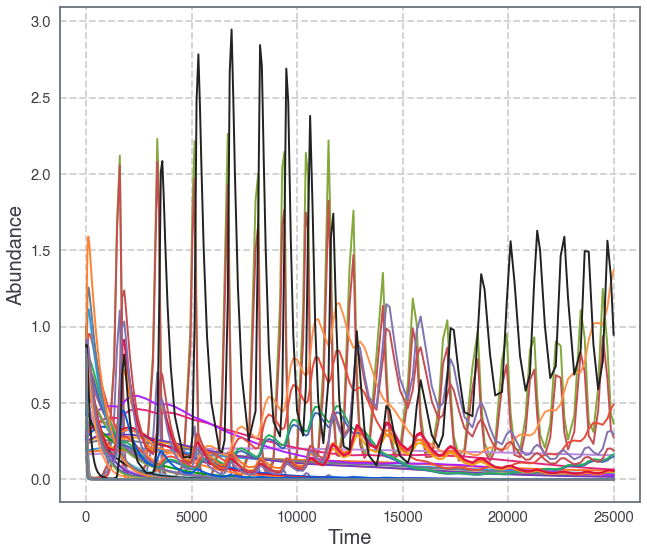

In [14]:
print(sol_2.y[:,-1])

plt.plot(sol_2.t, sol_2.y.T)
plt.xlabel('Time', fontsize = 20)
plt.ylabel('Abundance', fontsize = 20)
plt.savefig('resident_dynamics.png', dpi=600, bbox_inches='tight')
plt.show()

### Add invading catfish

In [11]:
size_data = np.genfromtxt('sizerange_invade.csv', delimiter=',')

tax_data = np.genfromtxt('taxonomy_invade.csv', delimiter=',', dtype = object)


dead_index = np.asarray([ i if i<ind_pp else i+1 for i in range(len(sol_2.y[:,- 1])) if sol_2.y[i,-1] < 10**-6 ])
    
x = np.insert(x, ind_pp, m[ind_pp]/bm[ind_pp] + np.random.normal(0,0.001*m[ind_pp],1)[0])

x = np.delete(x, dead_index, 0)

y0_orig = np.asarray([i for i in sol_2.y[:,-1] if i > 10**-6 ])

size_data = np.delete(size_data, dead_index, 0)

tax_data = np.delete(tax_data, dead_index, 0)

y0 = np.insert(y0_orig, np.argmin(size_data[:,0])+1, 0.1)

uninvad_pred = []

deviate_Atemp = []

deviate_Aui = []

deviate_y0 = []

deviate_solbest = []

deviate_Usol = []

invasion_fitness = []

diag = 0.01 ##### add a constant to the diagonal for uninvadable solutions

pred_success = []

rng = np.random.default_rng()

for i in range(1):
    
    n_sp = len(size_data)

    ind_pp = np.argmin(size_data[:,0]) + 1 ## Index of the invader/first consumer

    print(ind_pp)
    
    log_bodysize = np.log10(size_data[:,0])

    qrsupv = np.asarray([ -2.172, 1.264])   ### From ANM model Vagnon 2021
    qrinfv = np.asarray([ -2.065, 1.077 ])

    qrsupi = np.asarray([ 0.0, 0.82 ])
    qrinfi = np.asarray([ 0.0, 0.143 ])

    bs_rmin = np.asarray([ qrinfv[0] + qrinfv[1]*log_bodysize[i] if tax_data[i,1] in [b'Vertebrate'] else qrinfi[0] + qrinfi[1]*log_bodysize[i] for i in np.arange(ind_pp, n_sp)  ])

    bs_rmax = np.asarray([ qrsupv[0] + qrsupv[1]*log_bodysize[i] if tax_data[i,1] in [b'Vertebrate'] else qrsupi[0] + qrsupi[1]*log_bodysize[i] for i in np.arange(ind_pp, n_sp) ])

    bs_c = (bs_rmin + bs_rmax)/2

    mb =  np.zeros((n_sp, n_sp))

    mb[ind_pp:] = np.asarray([ [ 1 if bs_rmin[i-ind_pp] <= log_bodysize[j] <= bs_rmax[i-ind_pp] else 0 for j in range(n_sp) ] for i in np.arange(ind_pp,n_sp) ])

#     print(mb[ind_pp:])
    
    mb[ind_pp:] = np.asarray( [ [ 0 if tax_data[i,2] in [b'C'] and j<ind_pp
                                 else 0 if tax_data[i,2] in [b'H'] and j >= ind_pp
                                 else mb[i,j] for j in range(n_sp) ] for i in np.arange(ind_pp,n_sp)])

    mb = np.asarray( [[ 0 if tax_data[i,3] in [b'Littoral'] and tax_data[j,3] in [b'Pelagic']
                      else 0 if tax_data[i,3] in [b'Pelagic'] and tax_data[j,3] in [b'Littoral']
                      else mb[i,j] for j in range(n_sp)] for i in range(n_sp)] )
    
    mb[ind_pp:] = np.asarray([ [ stats.norm(bs_c[i-ind_pp], np.std(np.linspace(bs_rmin[i-ind_pp], bs_rmax[i-ind_pp], 100)) ).pdf(log_bodysize[j])/stats.norm(bs_c[i-ind_pp], np.std(np.linspace(bs_rmin[i-ind_pp], bs_rmax[i-ind_pp], 100)) ).pdf(bs_c[i-ind_pp]) if mb[i,j]==1 else 0 for j in range(n_sp) ] for i in np.arange(ind_pp,n_sp) ])

    mb[ind_pp:] = (np.asarray([0 if np.max(mb[i])==0 else 1/np.max(mb[i]) for i in np.arange(ind_pp,n_sp)])*(mb[ind_pp:].T)).T

    A =  np.zeros((n_sp, n_sp))

    A[ind_pp:] = (np.asarray([0 if np.sum(mb[i])==0 else 1/np.sum(mb[i]) for i in np.arange(ind_pp,n_sp)])*(mb[ind_pp:].T)).T

    bm = 10**(3.24*np.log10(size_data[:,0]) - 15.465)

    m = 10**(0.71*np.log10(bm) - 0.018*(np.log10(bm))**2 - (3.125) )

    carn_invert = [tax_data[i,0] for i in range(n_sp) if tax_data[i,1] in [b'Invertebrate'] and tax_data[i,2] in [b'C',b'O'] ]

    herb_invert = [tax_data[i,0] for i in range(n_sp) if tax_data[i,1] in [b'Invertebrate'] and tax_data[i,2] in [b'H']  ]

    vertebrate = [tax_data[i,0] for i in range(n_sp) if tax_data[i,1] in [b'Vertebrate'] ]

    zooplank = [tax_data[i,0] for i in range(n_sp) if tax_data[i,1] in [b'Zooplankton'] ]

    unicell = [tax_data[i,0] for i in range(n_sp) if tax_data[i,1] in [b'Phytobenthos', b'Phytoplankton'] ]

    cmax = np.asarray([ 4 if tax_data[i,0] in vertebrate else 8 if tax_data[i,0] in carn_invert
                       else 5 if tax_data[i,0] in herb_invert else 6.5 if tax_data[i,0] in zooplank
                       else 1.69 for i in range(n_sp)])

    eps = np.asarray([ 0.45 if tax_data[i,2] in [b'H',b'O'] else 0.85 for i in np.arange(ind_pp,n_sp) ])
    ##Note that first index in eps belongs to the invader
    
    K = np.asarray([ 10**(-0.77*np.log10(bm[i]) - 6) for i in range(ind_pp)])

    h = np.asarray([ [ (4.084*10**5)*bm[j]*bm[i]**-0.75 if tax_data[i,1] in [b'Vertebrate'] 
                      else 1/cmax[i] if tax_data[i,1] in [b'Invertebrate', b'Zooplankton'] 
                      else 0 for j in range(n_sp)] for i in range(n_sp) ])
    
    r = np.asarray([ m[i]/bm[i] for i in range(n_sp)])

    r[ind_pp:] = r[ind_pp:]*np.asarray([ 0.88 if tax_data[i,1] in [b'Vertebrate'] else 0.314 for i in np.arange(ind_pp,n_sp) ])

    A_temp = np.copy(A)
    
    sol_temp = integrate.solve_ivp(f_trophic, [0,5000], y0, args = (A_temp, r, K, n_sp))
    
    if np.amax(sol_temp.y[:,-1]) > 100:
        continue
    
    dead_index = [ i for i in range(len(sol_temp.y[:,-1])) if sol_temp.y[i,-1] < 10**-6 ]

    y0_alive = np.asarray( [sol_temp.y[i,len(sol_temp.t) - 1] for i in range(len(sol_temp.y[:,-1])) if sol_temp.y[i,-1] > 10**-6 ] )
    
    ### Check closest uninvadable equilibria ###
    
    A_ui = A_temp - np.eye(len(A_temp)) 
    
#     max_eig = np.amax(np.linalg.eigvals(A_ui + A_ui.T)) ## max_eig checks for negative definite matrix
    
#     if max_eig > 0: ## Working with a displaced matrix that is uninvadable
#         A_ui = A_ui - (max_eig/2+0.0001)*np.eye(len(A_ui))

    A_ui = A_ui - (diag)*np.eye(len(A_ui))
        
    fitness_0 = -r[ind_pp] + eps[0]*x[ind_pp]*cmax[ind_pp]*(A_temp[ind_pp]@y0)/(1 + (x[ind_pp]*cmax[ind_pp]*((h*A_temp)[ind_pp]@y0))) - A_temp.T[ind_pp]@(x*cmax*y0/(1 + (x*cmax*(h*A_temp).T).T@y0))
    
    print(fitness_0)
    
    sol_final = sol_temp.y[:,-1]
    
    extinct_ui = solbest_type2(A_temp,A_ui,fitness_0, sol_final, y0)
    
    print(extinct_ui)
        

3
-3.090728144664822e-05
0.00016329749971545718
0.08412963605685395
[26]


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


[4.98430989e-03 3.53010805e-03 8.02085401e-07 1.00552594e-01
 1.42974764e-05 4.25053616e-02 2.76568879e-02 2.94836916e-02
 1.29850148e-02 8.25293842e-03 7.97590652e-05 1.16255406e-01
 3.50631413e-05 1.37470891e-05 7.82346941e-02 4.61467991e-02
 5.37121924e-02 2.97963103e-03 3.11065136e-03 9.32716833e-03
 5.42450506e-02 3.75602119e-02 1.60558543e-05 4.85606057e-02
 5.45875817e-02 1.92934273e-01 2.01477457e-01 1.53851924e-07]


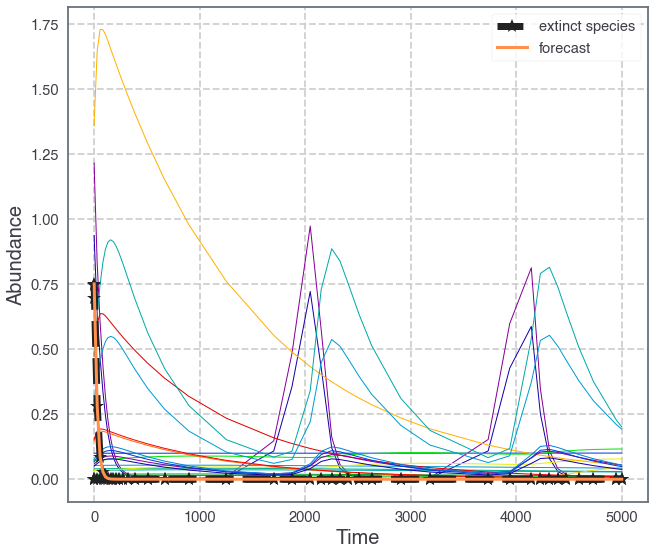

In [140]:
print(sol_temp.y[:,-1])

plt.rc( 'axes', prop_cycle=cycler.cycler(color = plt.cm.nipy_spectral( np.linspace(0.1,0.9,20)) ) )

plt.plot(sol_temp.t, sol_temp.y.T, linewidth = 1)
dead_plot = plt.plot(sol_temp.t, sol_temp.y[dead_index,:].T, '--k*', linewidth = 7, markersize = 15, label = 'extinct species')
pred_plot = plt.plot(sol_temp.t, sol_temp.y[extinct_ui[0],:].T, '-y', linewidth = 3, label = 'forecast')
plt.legend(handles=[dead_plot[0], pred_plot[0]], loc='upper right')
plt.xlabel('Time', fontsize = 20)
plt.ylabel('Abundance', fontsize = 20)
plt.savefig('lake_forecast_single.eps', dpi=600, bbox_inches='tight')
plt.show()

## Forecasting invasion outcomes with varying metabolic rates

In [ ]:
size_data_res = np.genfromtxt('sizerange.csv', delimiter=',')

tax_data_res = np.genfromtxt('taxonomy.csv', delimiter=',', dtype = object)


size_data = np.genfromtxt('sizerange_invade.csv', delimiter=',')

tax_data = np.genfromtxt('taxonomy_invade.csv', delimiter=',', dtype = object)

extinct_full = []

extinct_pred = []


for i in range(100):
     
    n_sp = len(size_data_res)

    ind_pp = np.argmax(size_data_res[:,0]) ## Index of the first consumer (currently set to largest size)

    log_bodysize = np.log10(size_data_res[:,0])

    qrsupv = np.asarray([ -2.172, 1.264])   ### From ANM model Vagnon 2021
    qrinfv = np.asarray([ -2.065, 1.077 ])

    qrsupi = np.asarray([ 0.0, 0.82 ])
    qrinfi = np.asarray([ 0.0, 0.143 ])

    bs_rmin = np.asarray([ qrinfv[0] + qrinfv[1]*log_bodysize[i] if tax_data_res[i,1] in [b'Vertebrate'] else qrinfi[0] + qrinfi[1]*log_bodysize[i] for i in np.arange(ind_pp, n_sp)  ])

    bs_rmax = np.asarray([ qrsupv[0] + qrsupv[1]*log_bodysize[i] if tax_data_res[i,1] in [b'Vertebrate'] else qrsupi[0] + qrsupi[1]*log_bodysize[i] for i in np.arange(ind_pp, n_sp) ])

    bs_c = (bs_rmin + bs_rmax)/2

    mb =  np.zeros((n_sp, n_sp))

    mb[ind_pp:] = np.asarray([ [ 1 if bs_rmin[i-ind_pp] <= log_bodysize[j] <= bs_rmax[i-ind_pp] else 0 for j in range(n_sp) ] for i in np.arange(ind_pp,n_sp) ])

    mb[ind_pp:] = np.asarray( [ [ 0 if tax_data_res[i,2] in [b'C'] and j<ind_pp
                                 else 0 if tax_data_res[i,2] in [b'H'] and j >= ind_pp
                                 else mb[i,j] for j in range(n_sp) ] for i in np.arange(ind_pp,n_sp)])

    mb = np.asarray( [[ 0 if tax_data_res[i,3] in [b'Littoral'] and tax_data_res[j,3] in [b'Pelagic']
                      else 0 if tax_data_res[i,3] in [b'Pelagic'] and tax_data_res[j,3] in [b'Littoral']
                      else mb[i,j] for j in range(n_sp)] for i in range(n_sp)] )

    mb[ind_pp:] = np.asarray([ [ stats.norm(bs_c[i-ind_pp], np.std(np.linspace(bs_rmin[i-ind_pp], bs_rmax[i-ind_pp], 100)) ).pdf(log_bodysize[j]) if mb[i,j]==1 else 0 for j in range(n_sp) ] for i in np.arange(ind_pp,n_sp) ])

    mb[ind_pp:] = (np.asarray([0 if np.max(mb[i])==0 else 1/np.max(mb[i]) for i in np.arange(ind_pp,n_sp)])*(mb[ind_pp:].T)).T

    A =  np.zeros((n_sp, n_sp))

    A[ind_pp:] = (np.asarray([0 if np.sum(mb[i])==0 else 1/np.sum(mb[i]) for i in np.arange(ind_pp,n_sp)])*(mb[ind_pp:].T)).T

    bm = 10**(3.24*np.log10(size_data_res[:,0]) - 15.465)

    log_bm = 3.24*np.log10(size_data_res[:,0]) - 15.465

    m = 10**(0.71*np.log10(bm) - 0.018*(np.log10(bm))**2 - (3.125) )

    log_m = 0.71*np.log10(bm) - 0.018*(np.log10(bm))**2 - (3.125)

    carn_invert = [tax_data_res[i,0] for i in range(n_sp) if tax_data_res[i,1] in [b'Invertebrate'] and tax_data_res[i,2] in [b'C',b'O'] ]

    herb_invert = [tax_data_res[i,0] for i in range(n_sp) if tax_data_res[i,1] in [b'Invertebrate'] and tax_data_res[i,2] in [b'H']  ]

    vertebrate = [tax_data_res[i,0] for i in range(n_sp) if tax_data_res[i,1] in [b'Vertebrate'] ]

    zooplank = [tax_data_res[i,0] for i in range(n_sp) if tax_data_res[i,1] in [b'Zooplankton'] ]

    unicell = [tax_data_res[i,0] for i in range(n_sp) if tax_data_res[i,1] in [b'Phytobenthos', b'Phytoplankton'] ]

    cmax = np.asarray([ 4 if tax_data_res[i,0] in vertebrate else 8 if tax_data_res[i,0] in carn_invert
                       else 5 if tax_data_res[i,0] in herb_invert else 6.5 if tax_data_res[i,0] in zooplank
                       else 1.69 for i in range(n_sp)])

    eps = np.asarray([ 0.45 if tax_data_res[i,2] in [b'H',b'O'] else 0.85 for i in np.arange(ind_pp,n_sp) ])

    K = np.asarray([ 10**(-0.77*np.log10(bm[i]) - 6) for i in range(ind_pp)])

    h = np.asarray([ [ (4.084*10**5)*bm[j]*bm[i]**-0.75 if tax_data_res[i,1] in [b'Vertebrate'] 
                      else 1/cmax[i] if tax_data_res[i,1] in [b'Invertebrate', b'Zooplankton'] 
                      else 0 for j in range(n_sp)] for i in range(n_sp) ])

    x = np.asarray([ m[i]/bm[i] + np.random.normal(0,0.001*m[i],1)[0] for i in range(n_sp) ])

    r = np.asarray([ m[i]/bm[i] for i in range(n_sp)])

    r[ind_pp:] = r[ind_pp:]*np.asarray([ 0.88 if tax_data_res[i,1] in [b'Vertebrate'] else 0.314 for i in np.arange(ind_pp,n_sp) ])

    n0_sorted = np.sort(np.random.uniform(0.15,1,n_sp))

    n0 = np.asarray([ n0_sorted[i - ind_pp] if i>=ind_pp else n0_sorted[-ind_pp + i] for i in range(n_sp) ])

    sol_2 = integrate.solve_ivp(f_trophic, [0,25000], n0, args = (A,r,K,n_sp) )

    
    size_data = np.genfromtxt('sizerange_invade.csv', delimiter=',')

    tax_data = np.genfromtxt('taxonomy_invade.csv', delimiter=',', dtype = object)
    
    tax_data_full = np.genfromtxt('taxonomy_invade.csv', delimiter=',', dtype = object)

    dead_index = np.asarray([ i if i<ind_pp else i+1 for i in range(len(sol_2.y[:,- 1])) if sol_2.y[i,-1] < 10**-6 ])


    x = np.insert(x, ind_pp, m[ind_pp]/bm[ind_pp] + np.random.normal(0,0.001*m[ind_pp],1)[0])

    x = np.delete(x, dead_index, 0)

    y0_orig = np.asarray([i for i in sol_2.y[:,-1] if i > 10**-6 ])

    size_data = np.delete(size_data, dead_index, 0)

    tax_data = np.delete(tax_data, dead_index, 0)


    y0 = np.insert(y0_orig, np.argmin(size_data[:,0])+1, 0.1)

    diag = 0.01 ##### add a constant to the diagonal for uninvadable solutions

    pred_success = []

    rng = np.random.default_rng()


    
    n_sp = len(size_data)

    ind_pp = np.argmin(size_data[:,0]) + 1 ## Index of the invader/first consumer

    print(ind_pp)
    
    log_bodysize = np.log10(size_data[:,0])

    qrsupv = np.asarray([ -2.172, 1.264])
    qrinfv = np.asarray([ -2.065, 1.077 ])

    qrsupi = np.asarray([ 0.0, 0.82 ])
    qrinfi = np.asarray([ 0.0, 0.143 ])

    bs_rmin = np.asarray([ qrinfv[0] + qrinfv[1]*log_bodysize[i] if tax_data[i,1] in [b'Vertebrate'] else qrinfi[0] + qrinfi[1]*log_bodysize[i] for i in np.arange(ind_pp, n_sp)  ])

    bs_rmax = np.asarray([ qrsupv[0] + qrsupv[1]*log_bodysize[i] if tax_data[i,1] in [b'Vertebrate'] else qrsupi[0] + qrsupi[1]*log_bodysize[i] for i in np.arange(ind_pp, n_sp) ])

    bs_c = (bs_rmin + bs_rmax)/2

    mb =  np.zeros((n_sp, n_sp))

    mb[ind_pp:] = np.asarray([ [ 1 if bs_rmin[i-ind_pp] <= log_bodysize[j] <= bs_rmax[i-ind_pp] else 0 for j in range(n_sp) ] for i in np.arange(ind_pp,n_sp) ])

#     print(mb[ind_pp:])
    
    mb[ind_pp:] = np.asarray( [ [ 0 if tax_data[i,2] in [b'C'] and j<ind_pp
                                 else 0 if tax_data[i,2] in [b'H'] and j >= ind_pp
                                 else mb[i,j] for j in range(n_sp) ] for i in np.arange(ind_pp,n_sp)])

    mb = np.asarray( [[ 0 if tax_data[i,3] in [b'Littoral'] and tax_data[j,3] in [b'Pelagic']
                      else 0 if tax_data[i,3] in [b'Pelagic'] and tax_data[j,3] in [b'Littoral']
                      else mb[i,j] for j in range(n_sp)] for i in range(n_sp)] )
    
    mb[ind_pp:] = np.asarray([ [ stats.norm(bs_c[i-ind_pp], np.std(np.linspace(bs_rmin[i-ind_pp], bs_rmax[i-ind_pp], 100)) ).pdf(log_bodysize[j])/stats.norm(bs_c[i-ind_pp], np.std(np.linspace(bs_rmin[i-ind_pp], bs_rmax[i-ind_pp], 100)) ).pdf(bs_c[i-ind_pp]) if mb[i,j]==1 else 0 for j in range(n_sp) ] for i in np.arange(ind_pp,n_sp) ])

    mb[ind_pp:] = (np.asarray([0 if np.max(mb[i])==0 else 1/np.max(mb[i]) for i in np.arange(ind_pp,n_sp)])*(mb[ind_pp:].T)).T

    A =  np.zeros((n_sp, n_sp))

    A[ind_pp:] = (np.asarray([0 if np.sum(mb[i])==0 else 1/np.sum(mb[i]) for i in np.arange(ind_pp,n_sp)])*(mb[ind_pp:].T)).T

    bm = 10**(3.24*np.log10(size_data[:,0]) - 15.465)

    m = 10**(0.71*np.log10(bm) - 0.018*(np.log10(bm))**2 - (3.125) )

    carn_invert = [tax_data[i,0] for i in range(n_sp) if tax_data[i,1] in [b'Invertebrate'] and tax_data[i,2] in [b'C',b'O'] ]

    herb_invert = [tax_data[i,0] for i in range(n_sp) if tax_data[i,1] in [b'Invertebrate'] and tax_data[i,2] in [b'H']  ]

    vertebrate = [tax_data[i,0] for i in range(n_sp) if tax_data[i,1] in [b'Vertebrate'] ]

    zooplank = [tax_data[i,0] for i in range(n_sp) if tax_data[i,1] in [b'Zooplankton'] ]

    unicell = [tax_data[i,0] for i in range(n_sp) if tax_data[i,1] in [b'Phytobenthos', b'Phytoplankton'] ]

    cmax = np.asarray([ 4 if tax_data[i,0] in vertebrate else 8 if tax_data[i,0] in carn_invert
                       else 5 if tax_data[i,0] in herb_invert else 6.5 if tax_data[i,0] in zooplank
                       else 1.69 for i in range(n_sp)])

    eps = np.asarray([ 0.45 if tax_data[i,2] in [b'H',b'O'] else 0.85 for i in np.arange(ind_pp,n_sp) ])
    ##Note that first index in eps belongs to the invader
    
    K = np.asarray([ 10**(-0.77*np.log10(bm[i]) - 6) for i in range(ind_pp)])

    h = np.asarray([ [ (4.084*10**5)*bm[j]*bm[i]**-0.75 if tax_data[i,1] in [b'Vertebrate'] 
                      else 1/cmax[i] if tax_data[i,1] in [b'Invertebrate', b'Zooplankton'] 
                      else 0 for j in range(n_sp)] for i in range(n_sp) ])
    
    r = np.asarray([ m[i]/bm[i] for i in range(n_sp)])

    r[ind_pp:] = r[ind_pp:]*np.asarray([ 0.88 if tax_data[i,1] in [b'Vertebrate'] else 0.314 for i in np.arange(ind_pp,n_sp) ])

    A_temp = np.copy(A)
    
    sol_temp = integrate.solve_ivp(f_trophic, [0,5000], y0, args = (A_temp, r, K, n_sp))
    
    if np.amax(sol_temp.y[:,-1]) > 100:
        continue
    
    dead_index = [ i for i in range(len(sol_temp.y[:,-1])) if sol_temp.y[i,-1] < 10**-6 ]

    y0_alive = np.asarray( [sol_temp.y[i,len(sol_temp.t) - 1] for i in range(len(sol_temp.y[:,-1])) if sol_temp.y[i,-1] > 10**-6 ] )
    
    ### Check closest uninvadable equilibria ###
    
    A_ui = A_temp - np.eye(len(A_temp)) 
    
#     max_eig = np.amax(np.linalg.eigvals(A_ui + A_ui.T)) ## max_eig checks for negative definite matrix
    
#     if max_eig > 0: ## Working with a displaced matrix that is uninvadable
#         A_ui = A_ui - (max_eig/2+0.0001)*np.eye(len(A_ui))

    A_ui = A_ui - (diag)*np.eye(len(A_ui))
        
    fitness_0 = -r[ind_pp] + eps[0]*x[ind_pp]*cmax[ind_pp]*(A_temp[ind_pp]@y0)/(1 + (x[ind_pp]*cmax[ind_pp]*((h*A_temp)[ind_pp]@y0))) - A_temp.T[ind_pp]@(x*cmax*y0/(1 + (x*cmax*(h*A_temp).T).T@y0))
    
    print(fitness_0)
    
    sol_final = sol_temp.y[:,-1]
    
    extinct_ui = solbest_type2(A_temp,A_ui,fitness_0, sol_final, y0)
    
    dead_orig_index = [ i for i in range(len(tax_data_full)) if tax_data_full[i,0] in tax_data[dead_index,0]]
    
    extinct_ui_orig_index = [ i for i in range(len(tax_data_full)) if tax_data_full[i,0] in tax_data[extinct_ui,0] ] 
    
    extinct_full.append(dead_orig_index)
    
    extinct_pred.append(extinct_ui_orig_index)
    
#     print(extinct_ui)
    
    print(dead_orig_index)
    
    print(extinct_ui_orig_index)
        



The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


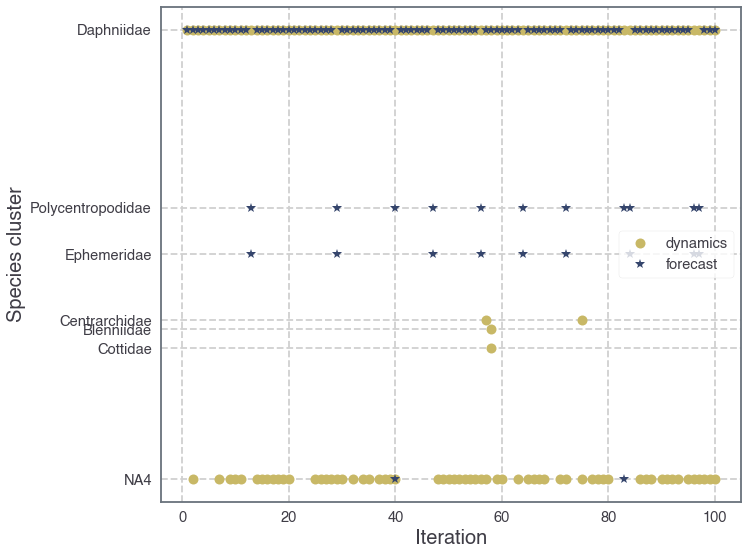

In [112]:
tax_data_full2 = np.genfromtxt('taxonomy_invade.csv', delimiter=',', dtype = None, encoding = 'utf-8' )

flat_extinct_full = [i for j in extinct_full for i in j]

flat_extinct_pred = [i for j in extinct_pred for i in j]

dead_ticks = np.concatenate( (np.unique(np.asarray(flat_extinct_full)), np.unique(np.asarray(flat_extinct_pred))), axis = 0)

dead_ticks = np.unique(dead_ticks)

plt.rc( 'axes', prop_cycle=cycler.cycler(color = plt.cm.cividis( np.linspace(0.2,0.85,2)) ) )
                    
for i in range(100):
    dead_plot = plt.plot(np.tile([i+1], len(extinct_full[i])), extinct_full[i], 'o', markersize=10, color = plt.cm.cividis(0.8), label = 'dynamics')
    
for i in range(100):
    pred_plot = plt.plot(np.tile([i+1], len(extinct_pred[i])), extinct_pred[i], '*', markersize=10, color = plt.cm.cividis(0.2), label = 'forecast')

plt.legend(handles=[dead_plot[0], pred_plot[0]], loc='center right')
# plt.yticks(np.arange(len(tax_data_full2)), tax_data_full2[:,0])
plt.yticks(dead_ticks, tax_data_full2[dead_ticks,0])

plt.xlabel('Iteration', fontsize=20)
plt.ylabel('Species cluster', fontsize=20)
plt.savefig('lake_forecast_iteration.eps', dpi=600, bbox_inches='tight')
plt.show()